In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import nltk
import string

In [3]:
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import feature_extraction

U prethodnom primeru smo videli na koje načine možemo da kreiramo `vokabular`, skup svih reči koje se pojavljuju u kolekciji tekstova kojom raspolažemo. Obično su ove reči leksikografski uređene, nalik popisu reči u rečnicima. U ovom primeru želimo da vidimo kako možemo doći do reprezentacija pogodnih za primenu algoritama mašinskog učenja. 

Tekstualna kolekcija nad kojom ćemo dalje eksperimentisati sadrži dve rečenice. To mogu biti i dva pasusa, dva dokumenta ili bilo koje druge tekstualne forme. 

In [4]:
corpus = ['This is so so so interesting!', 'Interesting is always better than non interesting.']

## Vreća reci (eng. Bag of Words)

Pretpostavimo da u vokabularu imamo `|V|` reči i da su one leksikografski uređene. Rečima možemo dodeliti redne brojeve koji odgovaraju pozicijama na kojima se nalaze. Rečenicu teksta stoga možemo predstaviti kao vektor dimenzije `|V|` u kojem se na poziciji `i` nalazi `1` ukoliko je `i`-ta reč vokabulara prisutna u rečenici ili `0` ukoliko se `i`-ta reč vokabulara ne nalazi u njoj. Ovakva reprezentacija rečenica (u opštem slučaju bilo kojih fragmenata teksta) gubi informaciju o povezanosti reči (rečenice *Tom likes Mary* i *Mary likes Tom* imaju iste reprezentacije i sasvim različitu semantiku) kao i informaciju o broju pojavljivanja određenih reči (što može biti važno za određivanje npr. teme teksta). Zato se ova reprezentacija može nadgraditi reprezentacijom u kojoj se na poziciji `i` nalazi `broj pojavljivanja reči` ili `0` ukoliko se ta reč ne javlja u rečenici. Ovakve reprezentacije i dalje nisu savršene jer ne uzimaju u obzir dužinu teksta - ukoliko je tekst dug reči se mogu pojavljivati neopravdano sa većom frekvencijom, i obratno.

<img src='assets/count_vectorizer.png'>

Bibiloteka `scikit-learn` sadrži klasu `CountVectorizer` koja nudi funkcionalnost vektorizacije teksta u model vreće reči sa frekvencijama (brojem pojavljivanja).

In [5]:
vectorized = feature_extraction.text.CountVectorizer()

Pozivom metode `fit` se kreira vokabular. Možemo primetiti da ona nudi par korisnih podešavanja:
- sve reči teksta je moguće svesti na mala slova (lowercase=True)
- moguće je eliminisati reči koje imaju frekvenciju pojavljivanja manju od min_df (npr. mogu se filtrirati razne pravopisne greške)
- moguće je eliminisati reči koje imaju frekvenciju veću od max_df (npr. mogu se eliminisati reči sa velikim frekvencijama poput članova ili predloga)
- moguće je zadati listu stop reči parametrom stop_words
- moguće je uticati na formu reči koje treba zadržati u vokabularu kroz token_pattern parametar
- kroz parametre preprocessor i tokenizer moguće je povezati se sa funkcionalnostima koje nude druge biblioteke 

In [6]:
vectorized.fit(corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Izdvojene reči i njima pridružene pozicije je moguće videti pomoću `get_feature_names` metode ili preko `vocabulary_` svojstva.

In [7]:
vectorized.get_feature_names()

['always', 'better', 'interesting', 'is', 'non', 'so', 'than', 'this']

In [8]:
vectorized.vocabulary_

{'this': 7,
 'is': 3,
 'so': 5,
 'interesting': 2,
 'always': 0,
 'better': 1,
 'than': 6,
 'non': 4}

In [9]:
len(vectorized.vocabulary_)

8

Sama transformacija polaznih rečenica se vrši metodom `transform`. U našem slučaju obe rečenice će biti predstavljene kao vektori dužine 8 pa je rezultat matrica dimenzije 2x8. 

In [10]:
corpus_bag_of_words = vectorized.transform(corpus)

In [11]:
corpus_bag_of_words.shape

(2, 8)

Sama matrica je `retka` matrica CSR formata u kojoj se pamte samo trojke (i, j, v) vrednosti indeksa vrsta i kolona ne-nula vrednosti. U realinim zadacima veličina vokabulara je obično velika, preko 10000 reči pa se ovakav dizajn pozitivno odražava na memorijske i računske zahteve. 

In [12]:
type(corpus_bag_of_words)

scipy.sparse.csr.csr_matrix

Ukoliko ipak želimo da dobijemo gustu reprezentaciju vektorizovanih rečenica, možemo to učiniti pozivom metode `toarray`.

In [13]:
corpus_bag_of_words.toarray()

array([[0, 0, 1, 1, 0, 3, 0, 1],
       [1, 1, 2, 1, 1, 0, 1, 0]])

## TF-IDF (Term Frequency - Inverse Document Frequency)

Reprezentacija rečenica vrećom reči (sa frekvencijama) se može unaprediti prelaskom na reprezentaciju sa trežinama. Težine bi trebale da reflektuju važnost reči u samoj rečenici, ali i važnost u odnosu na druge rečenice kolekcije. Jedna takva vektorska reprezentacija je Tf-Idf reprezentacija koja se uspešno koristi u mnogim NLP zadacima, na primer, u pretraživanju informacija (engl. information retrieval) ili istraživanju teksta (engl. text mining).
Tf je skraćenica od `term frequency`, a Idf skraćenica od `inverse document frequency`. U primeru koji mi razmatramo dokumenti su zapravo rečenice, ali se time ne gubi na opštosti ovog pristupa.

Neka je dalje: 
- $D = \{d_1, d_2\}$ - kolekcija rečenica/dokumenata
- $d_1 = $ 'This is so so so interesting!' - prva rečenica/dokument
- $d_2 = $ 'Interesting is always better than non interesting.' - druga rečenica/dokument



### Izračunavanje  Tf-Idf težina
Težina *tf-idf* je proizvod dva faktora:
- $Tf(t, d)$ - koji predstavlja količnik broja pojavljivanja reči/termina $t$ u dokumentu $d$ i ukupnog broja reči u dokumentu $d$
$$Tf(t, d) = \frac{count(t)}{|d|}$$
- $Idf(t, D)$ - koji predstavlja logaritam količnika ukupnog broja dokumenata skupa $D$ i broja dokumenata (iz skupa 
$D$) u kojima se pojavljuje termin $t$
$$Idf(t, D) = log(\frac{|D|}{N_t})$$


Dakle, $$TfIdf(t, d, D) =Tf(t, d)\cdot Idf(t, D)$$

Važnost termina (reči) raste sa rastom broja njegovog pojavljivanja u dokumentu, ali se otežava njegovim ukupnim brojem pojavljivanja u celokupnom skupu dokumenata (rečima koje se pojavljuju u većem broju dokumenata pridružuje se manja vrednost jer je i njihova diskriminativnost manja).

Postoje i mnoge varijacije na ovu temu o kojima se može više pročitati u članku na [Vikipediji](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). 

#### Primer
Razmotrimo dokument $d$ koji sadrži 100 reči u kojima se reč *mačka* pojavljuje 3 puta.

Tf("mačka", $d$) = $\frac{3}{100}$ = 0.03

Pretpostavimo da imamo *10 miliona* dokumenata i da se reč "mačka" pojavljuje u 1000 njih. 

Idf("mačka", $D$) = $\log{(\frac{10 000 000}{1 000})} = 4$

Mera *tf-idf* predstavlja proizvod nadjenih vrednosti, odnosno $TfIdf = 0.03 \cdot 4 = 0.12$.

Bibiloteka `scikit-learn` sadrži klasu `TfIdfVectorizer` koja nudi funkcionalnost vektorizacije teksta na gore opisani način.

In [14]:
tf_idf_vectorizer = feature_extraction.text.TfidfVectorizer()

Pozivom metode `fit` se, kao i u slučaju `CountVectorizer`-a, kreira vokabular. Metodu većinski prate i slični prateparametri, uz dodatak par novih: 
- parametrom `norm` se može uticati na metriku koja će se koristiti za normalizaciju vektorskih reprezentacija - to je podrazumevano `l2` norma
- parametrom `smooth_idf` se kontroliše deljenje nulom prilikom izračunavanja inverznih frekvencija dokumenata tako što se doda vrednost 1 u imeniocu za sve vrednosti 
- parametrom `use_idf` se može uticati na koriščenje Idf vrednosti u izračunavanju težina 

In [15]:
tf_idf_vectorizer.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [16]:
tf_idf_vectorizer.get_feature_names()

['always', 'better', 'interesting', 'is', 'non', 'so', 'than', 'this']

In [17]:
len(tf_idf_vectorizer.vocabulary_)

8

In [18]:
corpus_tfidf = tf_idf_vectorizer.transform(corpus)

In [19]:
corpus_tfidf.shape

(2, 8)

Vrednosti koje se nalaze u ovako dobijenoj reprezentaciji su sada realni brojevi. Vrste matrice su uvek normirane.

In [20]:
corpus_tfidf.toarray()

array([[0.        , 0.        , 0.21440614, 0.21440614, 0.        ,
        0.90402103, 0.        , 0.30134034],
       [0.39129369, 0.39129369, 0.55681737, 0.27840869, 0.39129369,
        0.        , 0.39129369, 0.        ]])

In [21]:
np.linalg.norm(corpus_tfidf.toarray()[0, :])

1.0

## Primer - SMS spam klasifikacija

U ovom primeru želimo da testiramo efektnost reprezentacija u zadatku klasifikacije sms poruka na spam i ne-spam poruke. 


U direktorijumu `smsspam` nalazi se datoteka `SMSSpamCollection` u kojoj se nalaze pomenute porukice.

Struktura je jedne linije dokumenta je sledeća:
```txt
LABELA\tSADRZAJ\n
```
Odnosno, prvo je navedena labela 
- `spam` - ukoliko je poruka spam
- `ham` - ukoliko poruka nije spam

potom karakter `\t`, a potom i sadržaj sms poruke sve do karaktera `\n`.


In [22]:
with open(os.path.join('smsspam', 'SMSSpamCollection')) as f:
    lines = [line.strip().split('\t') for line in f.readlines()]

Ukupan broj pročitanih porukica:

In [23]:
len(lines)

5574

Pročitane linije su transformisane u dvojke vrednosti: ham/spam labela i teskt poruke.

In [24]:
lines[0]

['ham',
 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...']

Razdvajamo tekstualni sadržaj i labele.

In [25]:
text = [line[1] for line in lines]
y = [int(line[0] == 'spam') for line in lines]

In [26]:
text[2000:2010]

["LMAO where's your fish memory when I need it?",
 "But i'll b going 2 sch on mon. My sis need 2 take smth.",
 'Idea will soon get converted to live:)',
 'TheMob>Yo yo yo-Here comes a new selection of hot downloads for our members to get for FREE! Just click & open the next link sent to ur fone...',
 'S....s...india going to draw the series after many years in south african soil..',
 'Goodmorning, today i am late for  &lt;DECIMAL&gt; min.',
 "Can't take any major roles in community outreach. You rock mel",
 'Shopping lor. Them raining mah hard 2 leave orchard.',
 'Hi here. have birth at on the  to  at 8lb 7oz. Mother and baby doing brilliantly.',
 'See the forwarding message for proof']

In [27]:
n_spam = y.count(1)
n_nospam = y.count(0)
print('Broj spam poruka: {}'.format(n_spam))
print('Broj poruka koje nisu spam: {}'.format(n_nospam))
print('Ukupan broj poruka: {}'.format(len(y)))
print('Udeo spam poruka među svim porukama: {}'.format(n_spam/len(y)))

Broj spam poruka: 747
Broj poruka koje nisu spam: 4827
Ukupan broj poruka: 5574
Udeo spam poruka među svim porukama: 0.1340150699677072


In [28]:
X_train, X_test, y_train, y_test =\
    model_selection.train_test_split(text, y, test_size=0.33, random_state=7, stratify=y)

Proverićamo prvo kavi rezultati klasifikacije se dobijaju ukoliko se koristi reprezentacija vreće reči. Prilikom odredjivanja vokabulara ignorisaćemo reči koje se pojavljuju manje od 2 puta. 

In [29]:
spam_vectorizer = feature_extraction.text.CountVectorizer(min_df=2)

Vektorajzer se po pravilu pokreće nad skupom za treniranja. Kasnije, kada se primeni nad skupom za testiranje, sve nepoznate reči tj. reči test skupa koje nisu prisutne u vokabularu, će biti ignorisane.

In [30]:
spam_vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=2,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [31]:
X_train_vectorized = spam_vectorizer.transform(X_train)
X_test_vectorized = spam_vectorizer.transform(X_test)

In [32]:
print('Broj reci u trening skupu {}'.format(X_train_vectorized.shape[0]))

Broj reci u trening skupu 3734


In [33]:
spam_vectorizer.get_feature_names()[2000:2020]

['oni',
 'onion',
 'online',
 'only',
 'onto',
 'onwards',
 'oops',
 'open',
 'operator',
 'opinion',
 'opinions',
 'opportunity',
 'opt',
 'optout',
 'or',
 'or2stoptxt',
 'orange',
 'orchard',
 'order',
 'oredi']

## Model logističke regresije

In [34]:
logistic_regression_model = linear_model.LogisticRegression()
logistic_regression_model.fit(X_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
logistic_regression_train_score = logistic_regression_model.score(X_train_vectorized, y_train)
print(logistic_regression_train_score)

0.9959828602035351


In [36]:
logistic_regression_test_score = logistic_regression_model.score(X_test_vectorized, y_test)
print(logistic_regression_test_score)

0.9820652173913044


## Linearni SVM model

In [37]:
svm_model = svm.LinearSVC(loss='hinge')
svm_model.fit(X_train_vectorized, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [38]:
svm_train_score = svm_model.score(X_train_vectorized, y_train)
print(svm_train_score)

0.999196572040707


In [39]:
svm_test_score = svm_model.score(X_test_vectorized, y_test)
print(svm_test_score)

0.9820652173913044


## Model k-najbližih suseda

In [40]:
knn_model = neighbors.KNeighborsClassifier(n_neighbors=4)
knn_model.fit(X_train_vectorized, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [41]:
knn_train_score = knn_model.score(X_train_vectorized, y_train)
print(knn_train_score)

0.9287627209426889


In [42]:
knn_test_score = knn_model.score(X_test_vectorized, y_test)
print(knn_test_score)

0.9135869565217392


Funkcija kojom se prikazuju reči vokabulara najzaslužnije za klasifikovanje poruka na spam i ne-spam poruke.

In [43]:
def visualize_coefficients(title, classifier, feature_names, n_top_features=25):
    coefs = classifier.coef_.ravel()
    
    positive_coefficients_indices = np.argsort(coefs)[-n_top_features:]
    negative_coefficients_indices = np.argsort(coefs)[:n_top_features]
    
    interesting_coefficients_indices =\
        np.hstack([negative_coefficients_indices,
                   positive_coefficients_indices])
    
    plt.figure(figsize=(15,5))
    plt.title(title)
    colors = ['orange' if c < 0 else 'cadetblue' for c in coefs[interesting_coefficients_indices]]
    plt.bar(np.arange(2 * n_top_features),
            coefs[interesting_coefficients_indices], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(2*n_top_features), feature_names[interesting_coefficients_indices], rotation=60, ha='right')

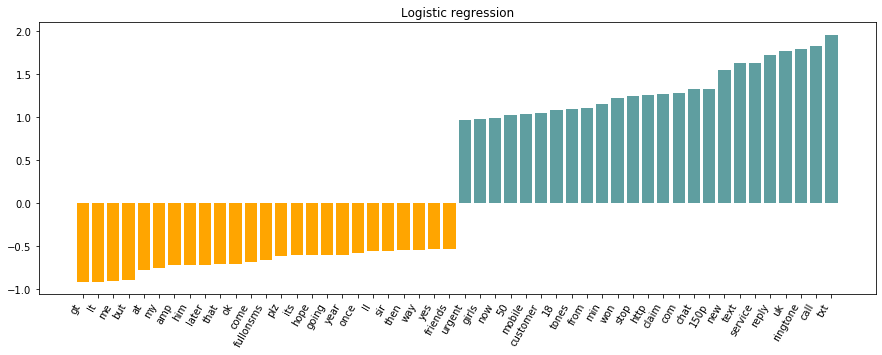

In [44]:
visualize_coefficients('Logistic regression',
                      logistic_regression_model,
                      spam_vectorizer.get_feature_names())

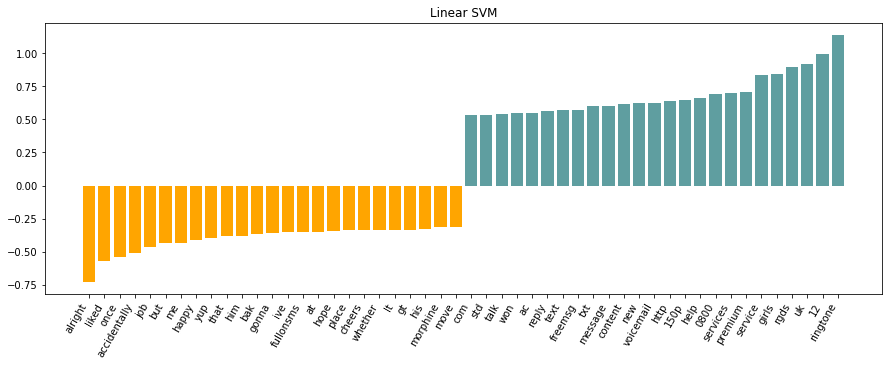

In [45]:
visualize_coefficients('Linear SVM',
                      svm_model,
                      spam_vectorizer.get_feature_names())

**Podsetnik**: `argsort` je funkcija koja se moze iskoristiti za dobijanje vrednosti indeksa koji dovode do sortiranja niza

In [47]:
tmp = np.array([1, 5, 2, 3])
sorted_tmp = np.argsort(tmp)
print(tmp[sorted_tmp])
print(sorted_tmp)

[1 2 3 5]
[0 2 3 1]


<div class='bg-info' style='padding: 20px'>
Zadaci za vežbu:
<ul>
    <li> Kako će se klasifikatori ponašati ukoliko se iskoristi Tf-Idf reprezentacija poruka? </li>
    <li> Ispitati kako će se klasifikatori ponašati ukoliko se izvrši priprema skupa funkcijom sms_tokenizer. Šta ova funkcija radi?</li>
</ul>
    
</div>

In [48]:
def sms_tokenizer(text):
    tokens = nltk.tokenize.word_tokenize(text)
            
    stems = []
    stemmer = nltk.stem.PorterStemmer()

    for token in tokens:
        if token in string.punctuation:
            continue
        if token.isdigit():
            continue
        stem = stemmer.stem(token)
        stems.append(stem)
    return stems

In [49]:
spam_vectorizer_2 = feature_extraction.text.CountVectorizer(min_df=2, tokenizer=sms_tokenizer)